Gender Detection using SIFT

Face Recogniotion using SIFT Feature and cobining SVM result with X gboost 
detecting face gender Male or Femal

Import needed library 

In [118]:
import pandas as pd
import os
import cv2
import numpy as np
import time
import glob
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,recall_score, classification_report,roc_curve, auc

1- Data Gathering 


Reading  the dataset Function that take the path of data set folder and read the image on gray level and sorted on Images list then encoded label to integer number and store it on Labels list 
(return two lists )

In [119]:
def ReadDataSet(path_of_dataSet):
   Images_List=[]
   labels_List=[]

   # Reading ......
   for directory_path in glob.glob(path_of_dataSet):
       label = directory_path.split("\\")[-1]
       for img_path in glob.glob(os.path.join(directory_path, "*.jpg")): #jpg
           img = cv2.imread(img_path,0)# 0 for indicate the  gray scale   
           Images_List.append(img)
           labels_List.append(label)
   # Label Encode      
   le = preprocessing.LabelEncoder()
   le.fit (labels_List)
   Encoded_labels_List = le.transform(labels_List)
   Images_List = np.array(Images_List , dtype='object')
   Encoded_labels_List = np.array(Encoded_labels_List)
   return Images_List , Encoded_labels_List

2- Feature Extraction / Selection 

using the SIFT to extract the interesting Key points and descriptors for each Image (Extraction)

the number of key points is theta that will be tunning to get the best value for this data set (Selection)

then return the descriptors list for each image as feature (Feature set)


References: https://github.com/Akhilesh64/Image-Classification-using-SIFT/blob/main/main.py 

In [120]:
def SIFT(Images_List, thresh):

  t0 = time.time()


  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des
  
  '''
  All  Images list are passed through the CalcFeatures functions
   which returns the descriptors which are appended to the features list and 
  then stacked vertically in the form of a numpy array.
  '''

  features = []
  for img in Images_List:
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)


  k = 150
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

  def bag_of_features(features, centres, k = 500):
      vec = np.zeros((1, k))
      for i in range(features.shape[0]):
          feat = features[i]
          diff = np.tile(feat, (k, 1)) - centres
          dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
          idx_dist = dist.argsort()
          idx = idx_dist[0]
          vec[0][idx] += 1
      return vec

  vec = []
  for img in Images_List:
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
  vec = np.vstack(vec)

  t1 = time.time()
  
  return vec, (t1-t0)

3- Classification 

Two classification used on this step Support Vector Machine (SVM) and Xgboost 

- Support Vector Machine (SVM)

** the parameter used ( kernal and gamma)


((kernel ))poly kernel have been choices because have return better accuracy the degree will be the default (The Best)


((gamma)) will be 0.6 it's the best after tuning


Performance Measurement calculated are  Accuracy , Confusion matrix and Report

In [121]:
def SVM_Classifier(DataSet,Label_List):
     # Split to Train and Test
     X_train, X_test, y_train, y_test = train_test_split(DataSet,Label_List,test_size=.2)
                             
     # define support vector classifier
     svm = SVC(kernel='poly',gamma = 0.6,probability=True) 
     svm.fit(X_train,y_train)
     y_pred = svm.predict(X_test)
     
     # calculate accuracy,confusion matrix, specificity, sensitive and Report
     accuracy = accuracy_score(y_test, y_pred)
     specificity = recall_score(y_test, y_pred,average= None)
     sensitive = recall_score(np.logical_not(y_test) , np.logical_not(y_pred),average= None)
     report = classification_report(y_test, y_pred,zero_division =1, target_names=['Female', 'Male'])
     conf_mat = confusion_matrix(y_test, y_pred)
     
     #AUC
     probabilities =svm.predict_proba(X_test)
     y_proba = probabilities[:, 1]
     # calculate false positive rate and true positive rate at different thresholds
     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)
     AUC = auc(false_positive_rate, true_positive_rate)

     return accuracy*100,conf_mat, specificity,sensitive,report,false_positive_rate,true_positive_rate, AUC

- XgBoost Classifier

Performance Measurement calculated are  Accuracy , Confusion matrix  and Report

In [122]:
def XgBoost_Classifier(DataSet,Label_List):
    # Split to Train and Test
     X_train, X_test, y_train, y_test = train_test_split(DataSet,Label_List,test_size=.2)
    
    # Classifcation
     model = xgb.XGBClassifier()
     model.fit(X_train,y_train)
     y_pred = model.predict(X_test)
     
     # Caculate accuracy,confusion_matrix specificity,sensitive,report
     accuracy= accuracy_score( y_pred,y_test)
     conf_mat = confusion_matrix(y_test, y_pred)
     specificity = recall_score(y_test, y_pred,average= None)
     sensitive = recall_score(np.logical_not(y_test) , np.logical_not(y_pred),average= None)
     report = classification_report(y_test, y_pred,zero_division =1, target_names=['Femal','male'])
     #  #AUC
     probabilities =model.predict_proba(X_test)
     y_proba = probabilities[:, 1]
     # calculate false positive rate and true positive rate at different thresholds
     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)
     AUC = auc(false_positive_rate, true_positive_rate)
    
     return accuracy*100,conf_mat ,specificity,sensitive,report ,false_positive_rate,true_positive_rate, AUC

Main


- Reading data set from folder and get the Images and label list 

- looping through different value of threshold ( 10, 26 ,5)


- getting the feature set then send it to classifier

Read the Dataset and Display the first sample 

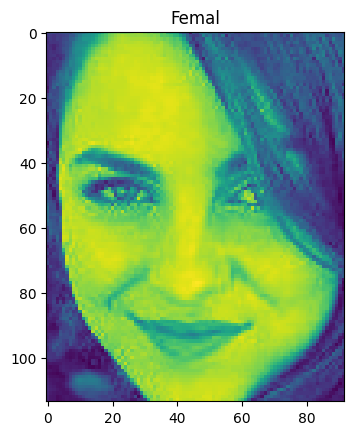

In [123]:
Image_List,Label_list =ReadDataSet(r"Data Set/*")
image = np.asarray(Image_List[0]).squeeze()
plt.imshow(image)
if Label_list[0] == 0:
    plt.title('Femal')
if Label_list[0] == 1:
    plt.title('MaLe')
plt.show()

Using SVM Classifier 

In [124]:

accuracy = []
threshold = []
SVM_report = [] 
for i in range(15,26,5): #SVM  15,26,5 
  print('\nCalculating for a threshold of {}'.format(i))
  feature, time_consuming  = SIFT(Image_List,i)
  data= SVM_Classifier(feature, Label_list)
  accuracy.append(data[0])
  threshold.append(i)
  SVM_report.append([data[2],data[3],data[4],data[1],data[5],data[6],data[7]])
  print('Accuracy', data[0])
  print('Time Consuming ', time_consuming)
  print('Confusion Matrix ',data[1])



Calculating for a threshold of 15
Accuracy 79.54545454545455
Time Consuming  6.2512524127960205
Confusion Matrix  [[59 11]
 [16 46]]

Calculating for a threshold of 20
Accuracy 73.48484848484848
Time Consuming  7.2151923179626465
Confusion Matrix  [[47 21]
 [14 50]]

Calculating for a threshold of 25
Accuracy 72.72727272727273
Time Consuming  8.598866939544678
Confusion Matrix  [[53 17]
 [19 43]]


Using Xgboost Classifier 

In [125]:
print('----- XgBoost_Classifier ------')
Xg_threshold = []
Xg_accuracy = []
Xg_report = []
for i in range(10,26,5):
  print('\nCalculating for a threshold of {}'.format(i))
  feature, time_consuming  = SIFT(Image_List,i)
  xgboostdata= XgBoost_Classifier(feature, Label_list)
  Xg_accuracy.append(xgboostdata[0])
  Xg_threshold.append(i)
  Xg_report.append([data[2],data[3],data[4],data[1],data[5],data[6],data[7]])
  print('Accuracy', xgboostdata[0])
  print('Time Consuming ', time_consuming)
  print('Confusion Matrix ',xgboostdata[1])


----- XgBoost_Classifier ------

Calculating for a threshold of 10
Accuracy 71.21212121212122
Time Consuming  5.388872861862183
Confusion Matrix  [[44 21]
 [17 50]]

Calculating for a threshold of 15
Accuracy 68.93939393939394
Time Consuming  6.516852617263794
Confusion Matrix  [[48 20]
 [21 43]]

Calculating for a threshold of 20
Accuracy 74.24242424242425
Time Consuming  7.392845153808594
Confusion Matrix  [[51 17]
 [17 47]]

Calculating for a threshold of 25
Accuracy 67.42424242424242
Time Consuming  8.367019653320312
Confusion Matrix  [[36 24]
 [19 53]]


4- Evaluation 

Comparing the SVM and Xgboost classifier which classifier provide the highest accuracy 

In [126]:
SVM_High_Acc = max(accuracy)
Xgboost_High_Acc = max(Xg_accuracy)
if SVM_High_Acc > Xgboost_High_Acc :
    index = accuracy.index(SVM_High_Acc)
    print('______ SVM have produce the high Accuracy_________')
    print('on threshold',threshold[index])    
    print('Accuracy is ',accuracy[index])
    print('specificity',SVM_report[index][0])
    print('sensitive',SVM_report[index][1])
    print('Confusion Matrix ',SVM_report[index][3])
    print('Report',SVM_report[index][2])
else:
    Xg_index = Xg_accuracy.index(Xgboost_High_Acc)
    print('Xgboost have produce the high Accuracy')
    print('on threshold',Xg_threshold[Xg_index]) 
    print('Accuracy is ',Xg_accuracy[Xg_index])
    print('specificity',Xg_report[Xg_index][0])
    print('sensitive',Xg_report[Xg_index][1])
    print('Confusion Matrix ',Xg_report[Xg_index][3])
    print('Report',Xg_report[Xg_index][2])   
    plt.plot(Xg_report[Xg_index][4],Xg_report[Xg_index][5],label='AUC = {:0.2f}'.format(Xg_report[Xg_index][6]))
    plt.plot([0,1], [0,1], ls='--')    
    plt.title('SIFT XgBoost Classifier')
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    plt.show()

______ SVM have produce the high Accuracy_________
on threshold 15
Accuracy is  79.54545454545455
specificity [0.84285714 0.74193548]
sensitive [0.74193548 0.84285714]
Confusion Matrix  [[59 11]
 [16 46]]
Report               precision    recall  f1-score   support

      Female       0.79      0.84      0.81        70
        Male       0.81      0.74      0.77        62

    accuracy                           0.80       132
   macro avg       0.80      0.79      0.79       132
weighted avg       0.80      0.80      0.79       132



Plot the AUC Curve for SIFT and Xgboost on high Threshold Accuracy 

High threshold 15


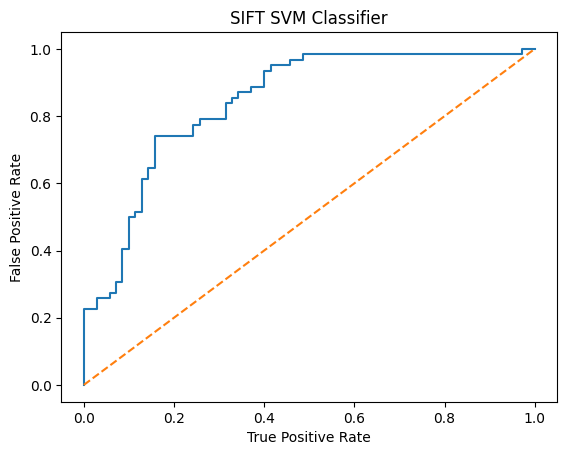

High threshold 20


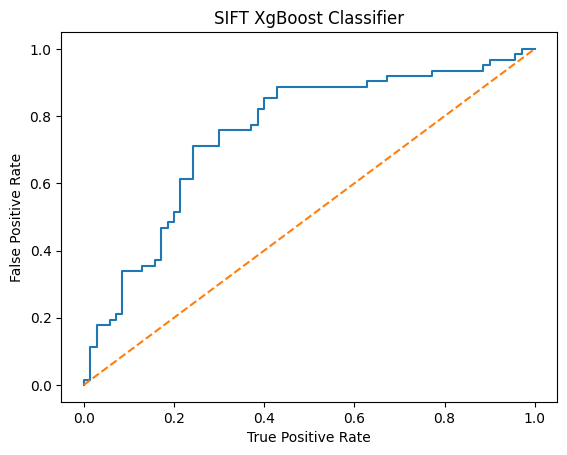

In [127]:
index= accuracy.index(SVM_High_Acc)
Xg_index = Xg_accuracy.index(Xgboost_High_Acc)
print('High threshold',threshold[index]) 
plt.plot(SVM_report[index][4],SVM_report[index][5],label='AUC = {:0.2f}'.format(SVM_report[index][6]))
plt.plot([0,1], [0,1], ls='--')    
plt.title('SIFT SVM Classifier')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show()
print('High threshold',Xg_threshold[Xg_index]) 
plt.plot(Xg_report[Xg_index][4],Xg_report[Xg_index][5],label='AUC = {:0.2f}'.format(Xg_report[Xg_index][6]))
plt.plot([0,1], [0,1], ls='--')    
plt.title('SIFT XgBoost Classifier')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show()

Export the result of two Classifer ( SVM and Xgboost) to Excel file

In [128]:
# Export SVM Result 
df = pd.DataFrame(columns=['threshold','accurecy'])
values = [threshold, accuracy]
for index,j in zip(df.columns,values):
    df[index] = j

df.to_excel('SVM Result.xlsx')

# Export Xgboost Result 
df = pd.DataFrame(columns=['threshold','accurecy'])
values = [Xg_threshold, Xg_accuracy]
for index,j in zip(df.columns,values):
    df[index] = j

df.to_excel('Xgboost Result.xlsx')
print('DataFrame is exported successfully to Excel File ')

DataFrame is exported successfully to Excel File 
